In [1]:
!pip install pytorch-metric-learning        # Biblioteka metod głębokiego uczenia metryki (deep metric learning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 57.3 MB/s 
     |████████████████████████████████| 418 kB 60.2 MB/s 
     |████████████████████████████████| 140 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.0 MB/s 


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from pytorch_metric_learning import samplers, miners, losses

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [3]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Sat Jun  4 21:37:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!python bboxes_extractor.py --save-dir data/reference_images_part1_bboxes --dir-from /content/drive/MyDrive/data/reference_images_part1 --data-json /content/drive/MyDrive/data/reference_images_part1.json

In [8]:
!python bboxes_extractor.py --save-dir data/images_part1_valid_bboxes --dir-from /content/drive/MyDrive/data/images_part1_valid --data-json /content/drive/MyDrive/data/images_part1_valid.json

# Dataset

In [9]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]
        self.class_names = self.img_labels.unique()

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[index]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [10]:
IMG_DIR = './data/reference_images_part1_bboxes/images'
LABELS_FILE = './data/reference_images_part1_bboxes/bboxes_data.csv'
IMG_DIR_VAL = './data/images_part1_valid_bboxes/images'
LABELS_FILE_VAL = './data/images_part1_valid_bboxes/bboxes_data.csv'

In [49]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [69]:
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=transformations)
val_data = MagicDataset(img_dir=IMG_DIR_VAL, labels_file=LABELS_FILE_VAL, transform=transformations)

In [70]:
EXAMPLES_PER_CLASS = 2
train_sampler = samplers.MPerClassSampler(labels=train_data.class_names, m=EXAMPLES_PER_CLASS)
val_sampler = samplers.MPerClassSampler(labels=val_data.class_names, m=EXAMPLES_PER_CLASS)

In [71]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, sampler=val_sampler)

In [16]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # unnormalize 
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

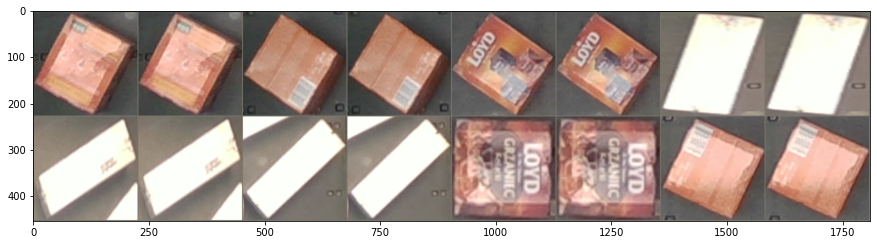

In [53]:
images, labels = next(iter(train_loader))

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(images[:16]))

# Model 

In [100]:
model = models.resnet18(pretrained=True)

for i, child in enumerate(model.children()):
    if i < 7:
        for param in child.parameters():
            param.requires_grad = False

model = torch.nn.Sequential(*(list(model.children())[:-1]), torch.nn.Flatten())
model = model.to(device)

In [ ]:
NUM_EPOCHS = 2
MARGIN = 5

miner = miners.BatchHardMiner()
criterion = losses.TripletMarginLoss(margin=MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        embeddings = model(inputs)
        triplets = miner(embeddings, labels)
        loss = criterion(embeddings, labels, triplets)

        epoch_loss += loss.item()
 
        loss.backward()
        optimizer.step()
    
    print(f"[{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss / len(train_loader)}")



In [ ]:
model.eval()

EMBEDDING_SIZE = 512
embeddings = torch.zeros((0, EMBEDDING_SIZE))
labels = torch.zeros((0))


with torch.no_grad():
    for ins, lbs in train_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels = torch.cat([labels.cpu(), lbs.cpu()])
        embeddings = torch.cat([embeddings.cpu(), model(ins).cpu()], dim=0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3) # metric='cosine'
knn.fit(embeddings.numpy(), labels.numpy())

KNeighborsClassifier(n_neighbors=3)

In [ ]:
labels_val = torch.zeros((0))
embeddings_val = torch.zeros((0, EMBEDDING_SIZE))

with torch.no_grad():
    for ins, lbs in val_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels_val = torch.cat([labels_val.cpu(), lbs.cpu()])
        embeddings_val = torch.cat([embeddings_val.cpu(), model(ins).cpu()], dim=0)

In [ ]:
PATH_TO_SAVE = 'drive/data'

torch.save(labels_val, os.path.join(PATH_TO_SAVE, 'labels_val.pt'))
torch.save(embeddings_val, os.path.join(PATH_TO_SAVE, 'embeddings_val.pt'))

In [ ]:
embeddings_val.numpy().shape

In [ ]:
preds = knn.predict(embeddings_val.numpy())

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(labels_val.numpy(), preds))